In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload


In [2]:
from matplotlib import pyplot as plt
import numpy as np
import time

In [7]:
from rxrmask.core import Atom, Structure, FormFactorLocalDB, ParametersContainer, FormFactorModel
from rxrmask.core import create_compound
from rxrmask.utils import plot_reflectivity, plot_energy_scan, plot_density_profile, get_density_profile_from_element_data
from rxrmask.backends import reflectivity_pr, reflectivity_parallel_pr, energy_scan_pr, energy_scan_parallel_pr

In [4]:
mn_ff = FormFactorLocalDB(element="Mn", is_magnetic=False)
o_ff = FormFactorLocalDB(element="O", is_magnetic=False)
sr_ff = FormFactorLocalDB(element="Sr", is_magnetic=False)
ti_ff = FormFactorLocalDB(element="Ti", is_magnetic=False)
c_ff = FormFactorLocalDB(element="C", is_magnetic=False)
la_ff = FormFactorLocalDB(element="La", is_magnetic=False)

la_atom = Atom(
    Z=57,
    name="La",
    ff=la_ff,
)
mn_atom = Atom(
    Z=25,
    name="Mn",
    ff=mn_ff,
)
o_atom = Atom(
    Z=8,
    name="O",
    ff=o_ff,
)
sr_atom = Atom(
    Z=38,
    name="Sr",
    ff=sr_ff,
)
ti_atom = Atom(
    Z=22,
    name="Ti",
    ff=ti_ff,
)
c_atom = Atom(
    Z=6,
    name="C",
    ff=c_ff,
)
x_atom = Atom(
    Z=0,
    name="X1",
    ff=FormFactorModel(),
)

In [ ]:
parameters_container = ParametersContainer()

comp_SrTiO3 = create_compound(
    parameters_container=parameters_container,
    name="SrTiO3",
    formula="Sr:1",
    thickness=50.0,
    density=5.12,
    atoms=[sr_atom, ti_atom, o_atom],
    roughness=5.3,
    prev_roughness=0.0,
    linked_prev_roughness=False,
)
comp_LaMnO3 = create_compound(
    parameters_container=parameters_container,
    name="LaMnO3",
    formula="La:3",
    thickness=10.0,
    density=6.52,
    atoms=[la_atom, mn_atom, o_atom, x_atom, c_atom],
    roughness=1.0,
    prev_roughness=0.0,
    linked_prev_roughness=True,
)
comp_CO2 = create_compound(
    parameters_container=parameters_container,
    name="CO2",
    formula="C:1",
    thickness=10.0,
    density=1.98,
    atoms=[c_atom, o_atom],
    roughness=10.0,
    prev_roughness=13.0,
    linked_prev_roughness=False,
)

struc = Structure(name=f"Test Structure", n_compounds=3, params_container=parameters_container)
struc.add_compound(0, comp_SrTiO3)
struc.add_compound(1, comp_LaMnO3)
struc.add_compound(2, comp_CO2)
struc.validate_compounds()
struc.create_layers(step=0.1)

  Sr:
    density_params: [0.05843414745491897, None, None, None]
    magnetic_density_params: [0.0, None, None, None]
    roughness_params: [5.3, None, None]
    thickness_params: [50.0, None, None]
  La:
    density_params: [None, 0.04693838616901418, None, None]
    magnetic_density_params: [None, 0.0, None, None]
    roughness_params: [5.3, 1.0, None]
    thickness_params: [None, 10.0, None]
  C:
    density_params: [None, None, 0.16484888851885773, None]
    magnetic_density_params: [None, None, 0.0, None]
    roughness_params: [None, 1.0, 10.0]
    thickness_params: [None, None, 10.0]


In [52]:
struc.print_details()

Structure: Test Structure
Number of compounds: 3
Number of layers: 850
Compound 0: SrTiO3
  Thickness: Parameter(value=50.0, id=5, name='SrTiO3-thickness', min_value=None, max_value=None, fit=False) Angstrom
  Density: Parameter(value=5.12, id=6, name='SrTiO3-density', min_value=None, max_value=None, fit=False) g/cm³
  Magnetic Density: Parameter(value=0.0, id=7, name='SrTiO3-magnetic_density', min_value=None, max_value=None, fit=False) mol/cm³
  Roughness: Parameter(value=1.0, id=8, name='SrTiO3-roughness', min_value=None, max_value=None, fit=False) Angstrom
  Previous Roughness: Parameter(value=0.0, id=9, name='SrTiO3-prev_roughness', min_value=None, max_value=None, fit=False) Angstrom
Compound 1: LaMnO3
  Thickness: Parameter(value=10.0, id=15, name='LaMnO3-thickness', min_value=None, max_value=None, fit=False) Angstrom
  Density: Parameter(value=6.52, id=16, name='LaMnO3-density', min_value=None, max_value=None, fit=False) g/cm³
  Magnetic Density: Parameter(value=0.0, id=17, name=

In [53]:
comp_SrTiO3.print_details()
comp_LaMnO3.print_details()

Compound: SrTiO3
  Formula: Sr:1
  Thickness: 50.0 Angstrom
  Density: 5.12 g/cm³
  Magnetic Density: 0.0 g/cm³
  Roughness: 1.0 Angstrom
  Previous Roughness: 0.0 Angstrom
  Linked Previous Roughness: False
  Magnetic: No
  Detail - 0: Sr - 1 50.0 Angstrom 1.0 Angstrom 0.0 Angstrom 0.05843414745491897 mol/cm³ 0.0 mol/cm³
Compound: LaMnO3
  Formula: La:3
  Thickness: 10.0 Angstrom
  Density: 6.52 g/cm³
  Magnetic Density: 0.0 g/cm³
  Roughness: 0.0 Angstrom
  Previous Roughness: 1.0 Angstrom
  Linked Previous Roughness: True
  Magnetic: No
  Detail - 0: La - 3 10.0 Angstrom 0.0 Angstrom 1.0 Angstrom 0.04693838616901418 mol/cm³ 0.0 mol/cm³


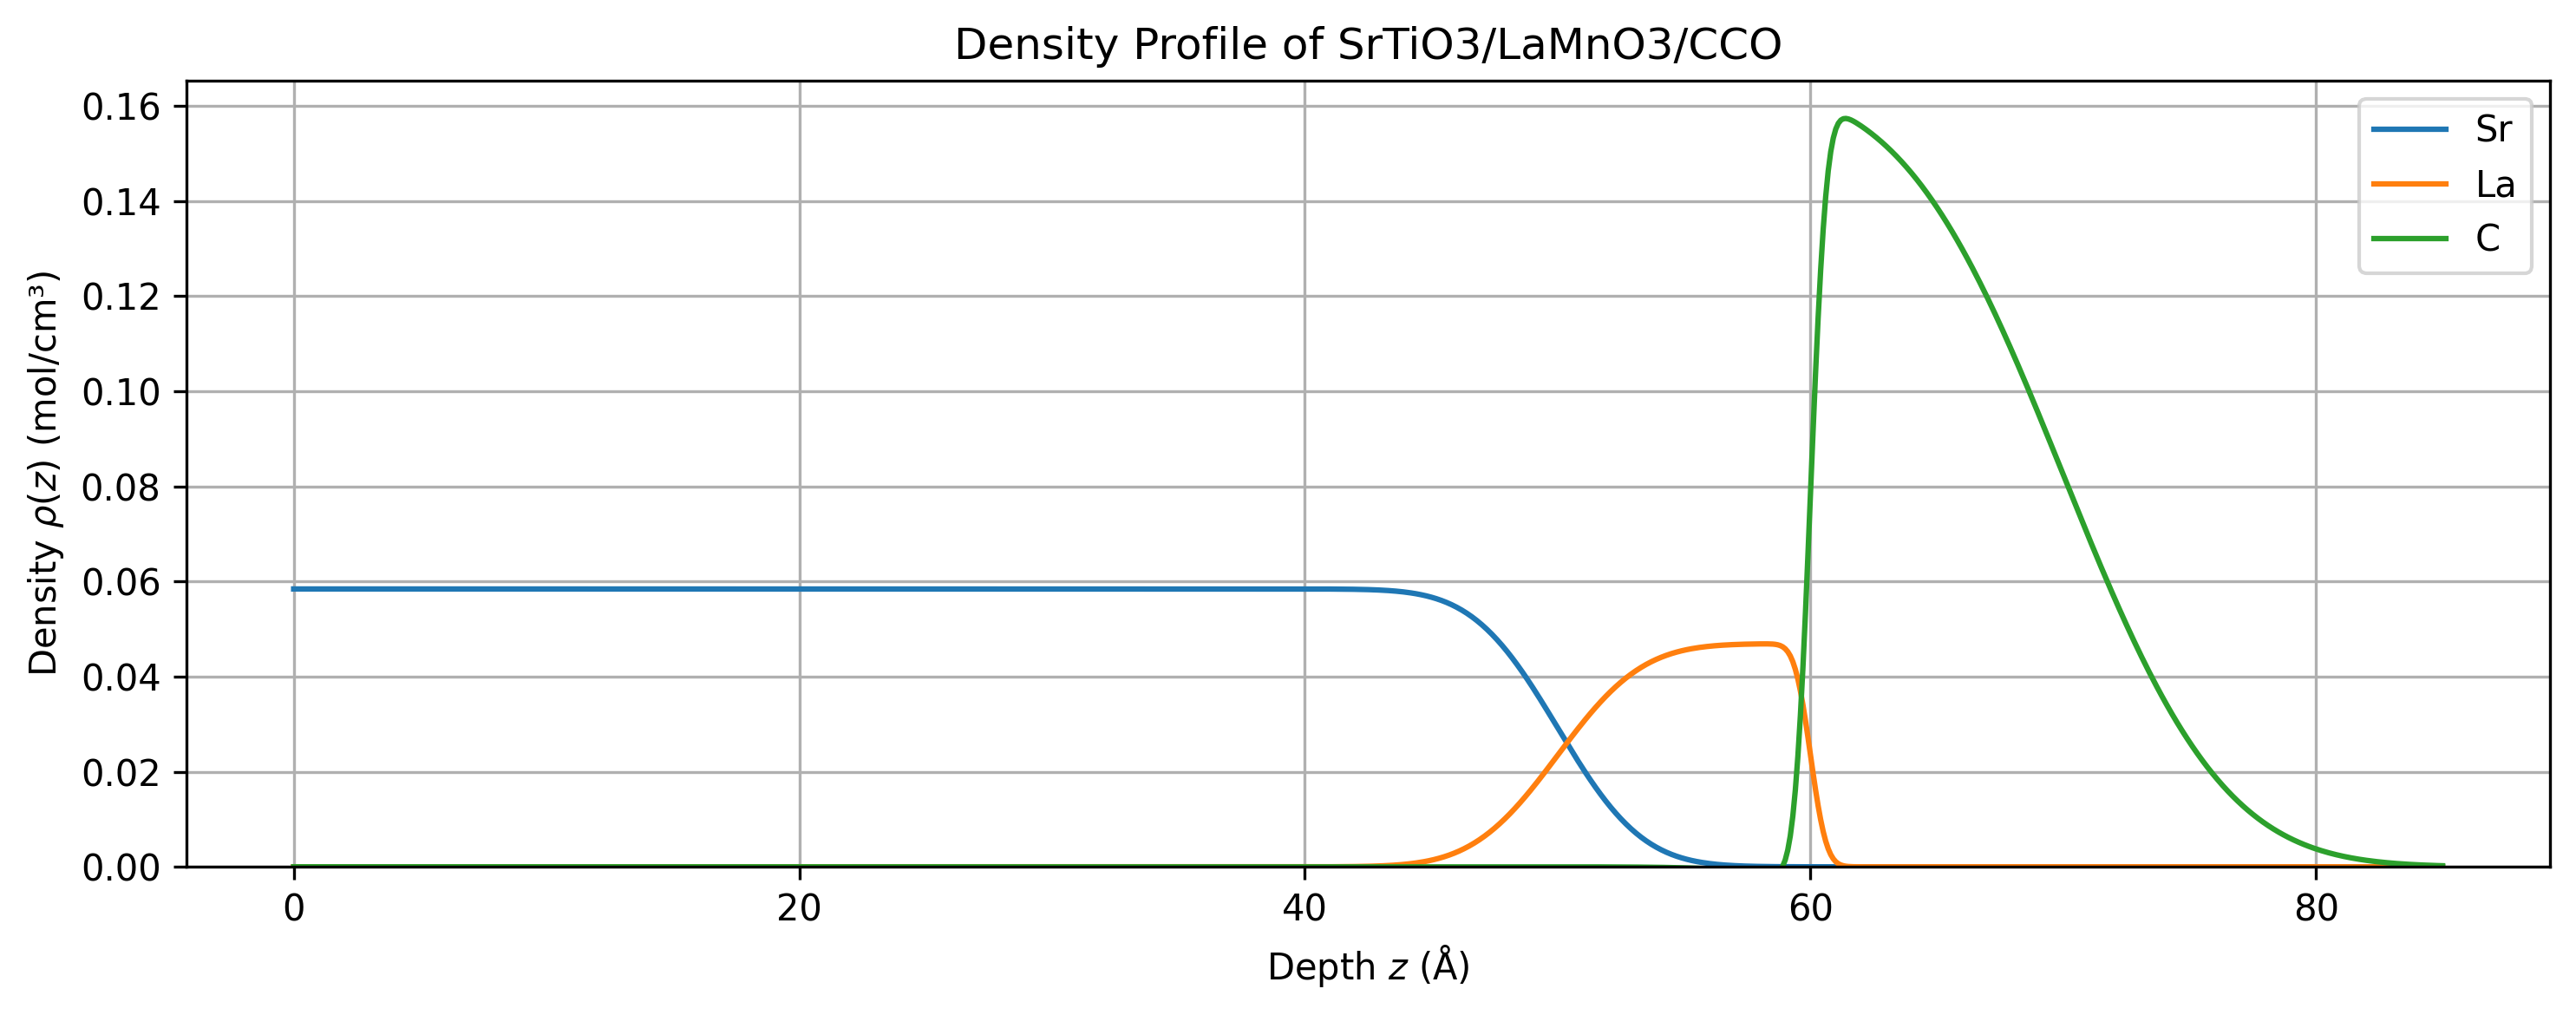

In [81]:
z, dens, m_dens, _ = get_density_profile_from_element_data(
    struc.element_data, struc.layer_thickness_params, struc.atoms, struc.step
)
plot_density_profile(z, dens, title="Density Profile of SrTiO3/LaMnO3/CCO")

Tiempo de ejecución: 0.093 segundos


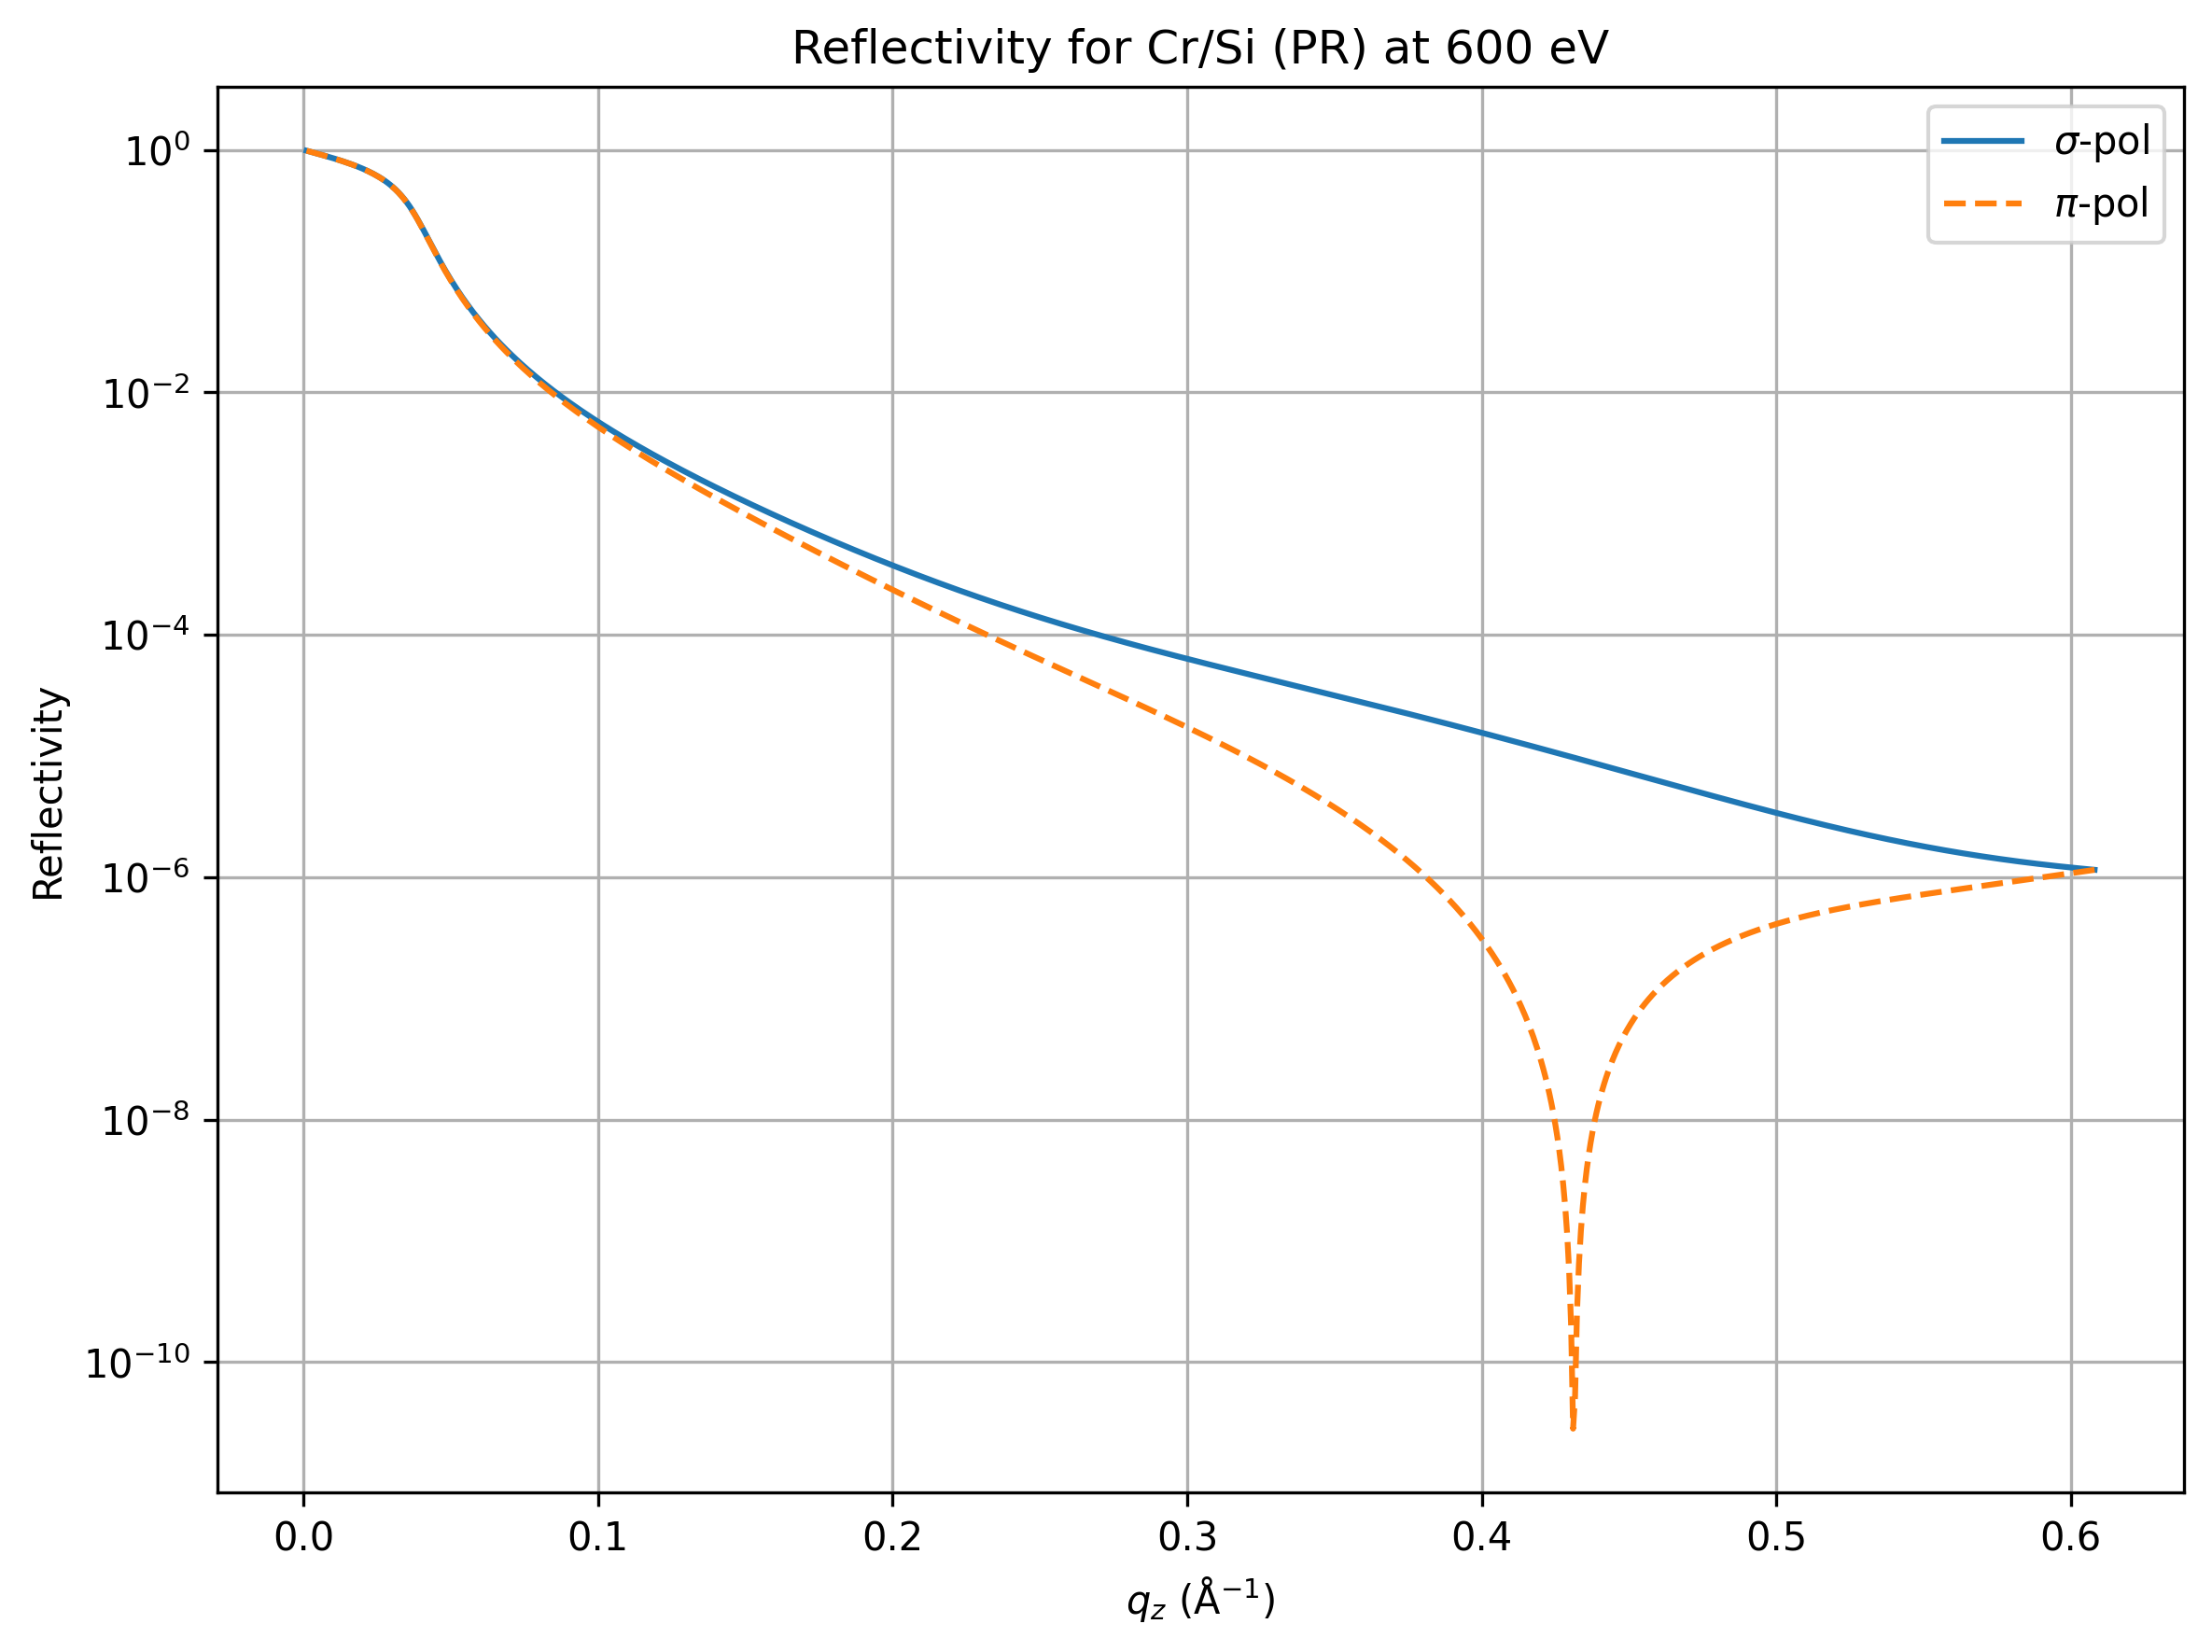

In [79]:

start_time = time.time()

E_eV = 600
Theta = np.linspace(0.1, 89.1, num=1001)
qz = np.sin(Theta * np.pi / 180) * (E_eV * 0.001013546143)

qz_pr, R_phi_pr, R_pi_pr  = reflectivity_pr(struc, qz, E_eV, als=True)
end_time = time.time()
print(f"Tiempo de ejecución: {end_time - start_time:.3f} segundos")

plot_reflectivity(qz_pr, R_phi_pr, R_pi_pr, E_eV, "Cr/Si (PR)")

Tiempo de ejecución: 0.435 segundos


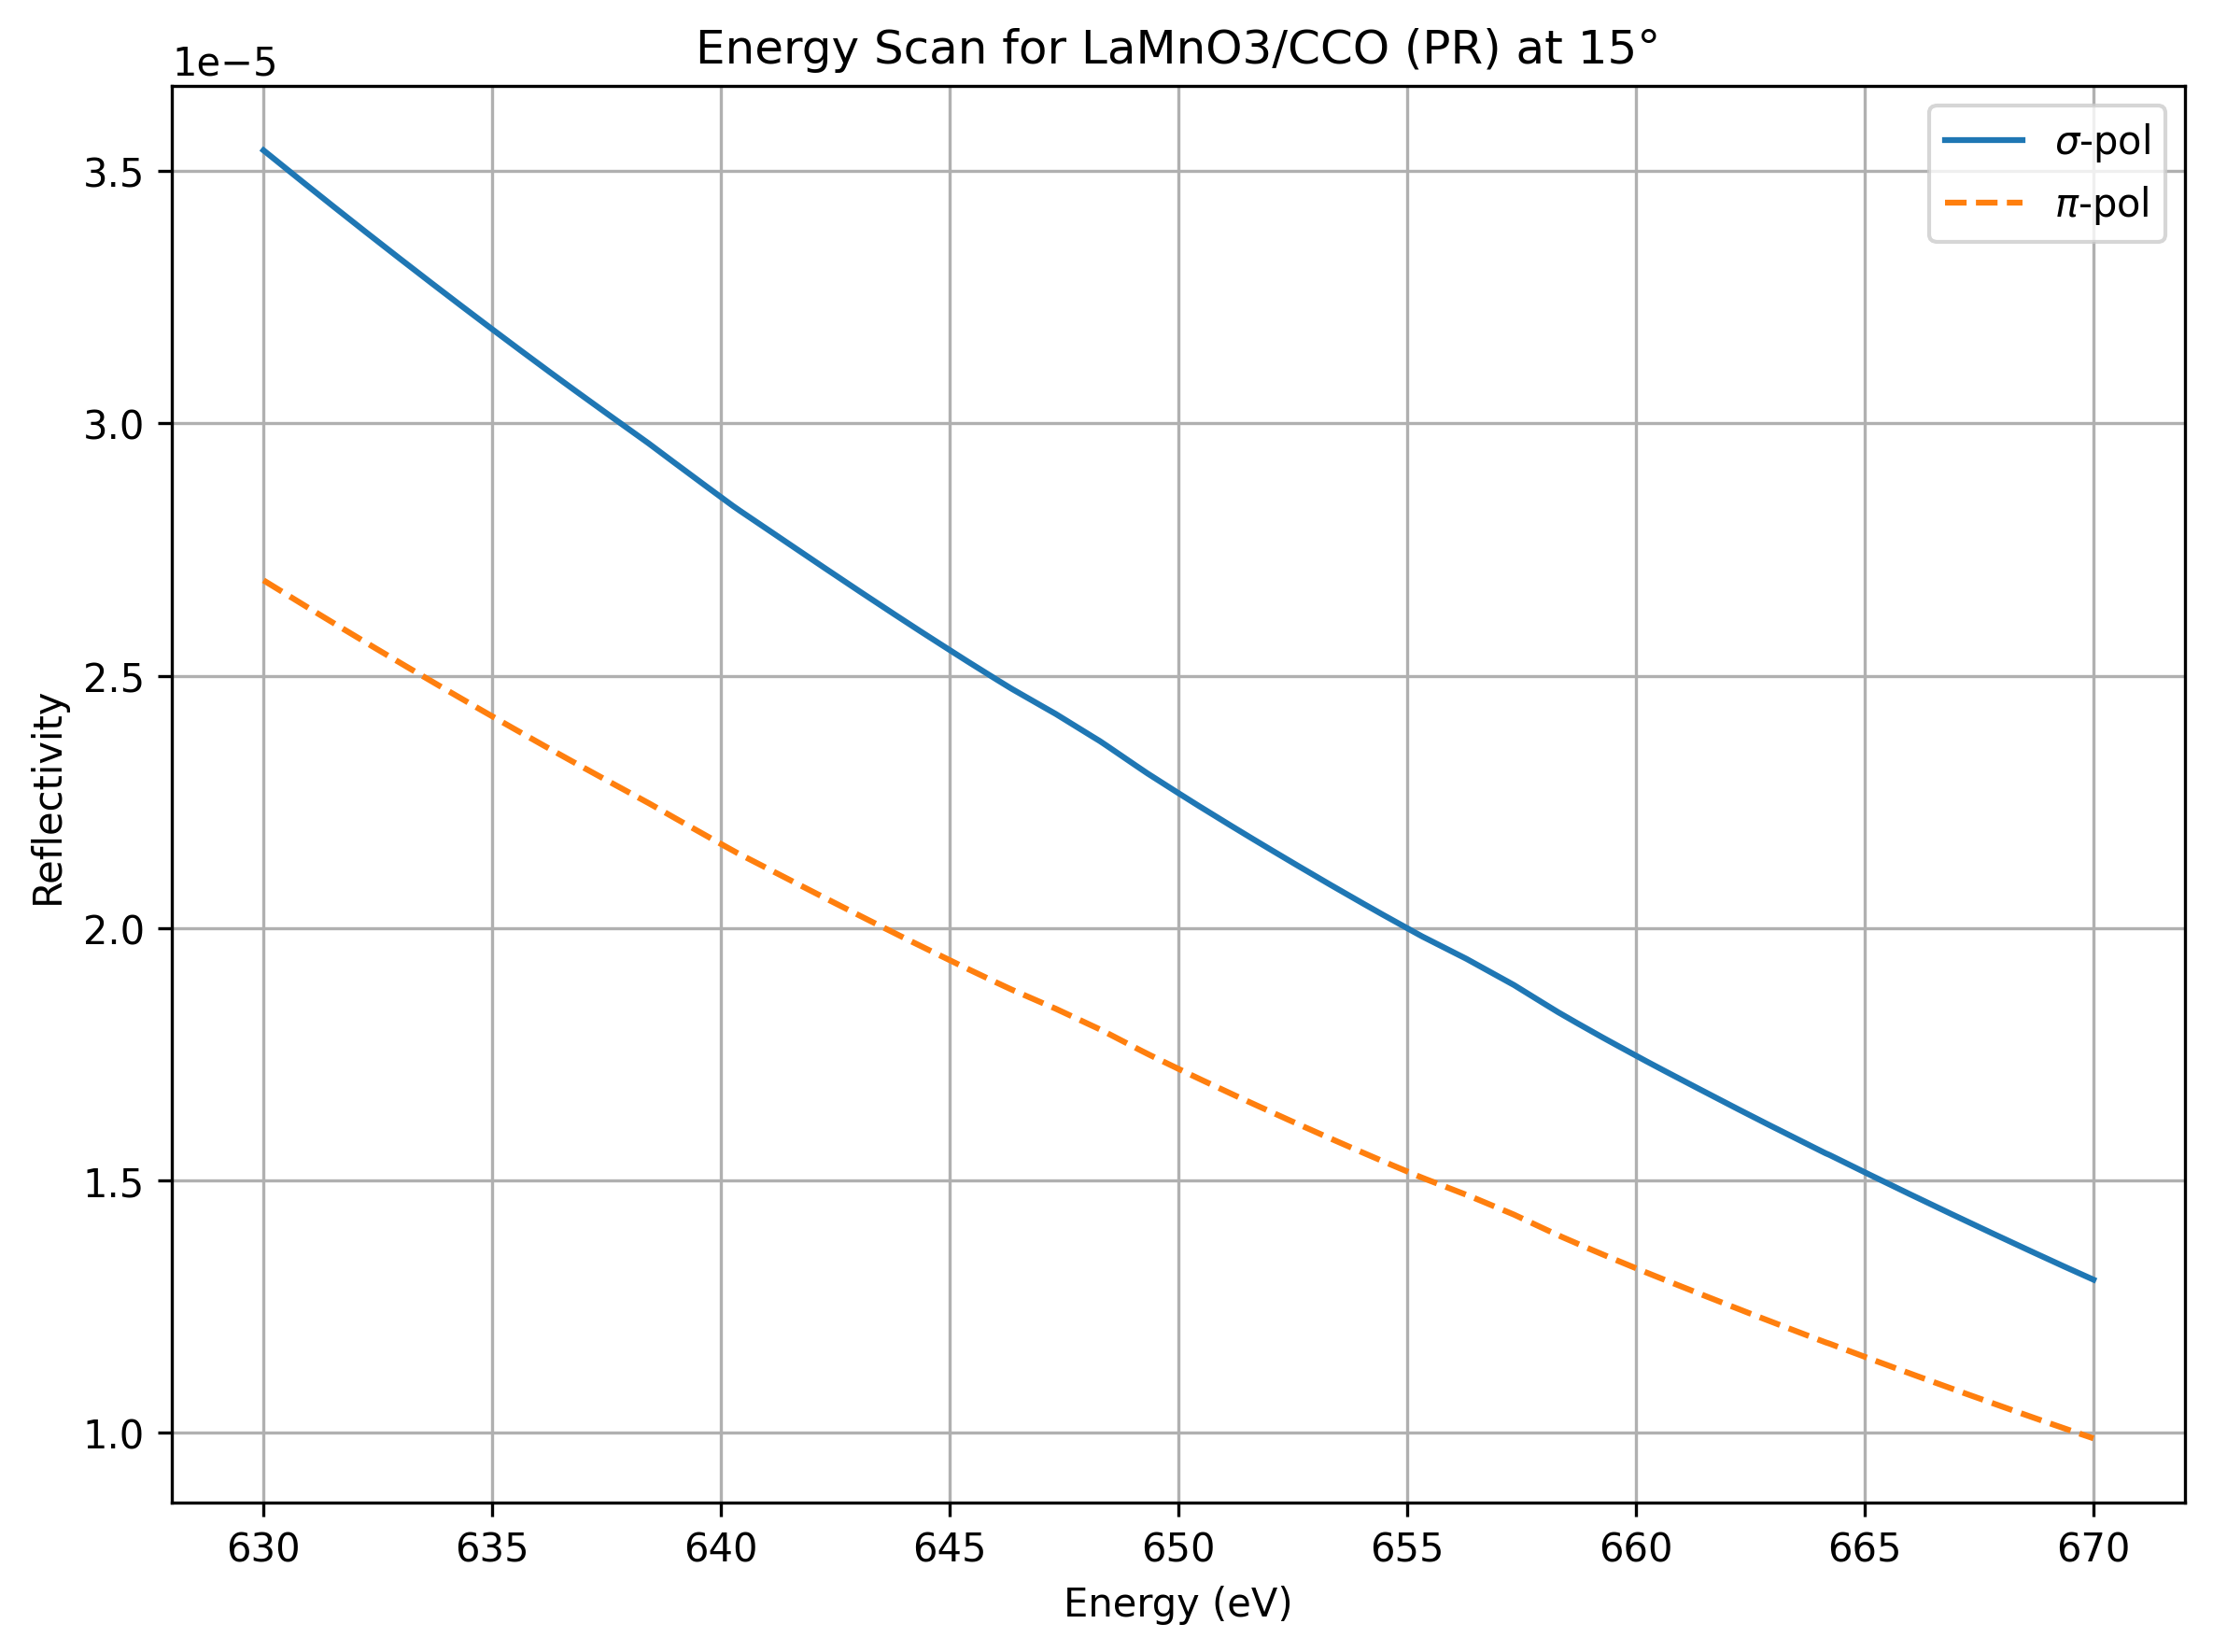

In [74]:
start_time = time.time()

e_evs = np.linspace(630, 670, num=500).tolist()
theta_deg = 15

e_pr, R_phi_pr, R_pi_pr  = energy_scan_pr(struc, e_evs, theta_deg)

end_time = time.time()
print(f"Tiempo de ejecución: {end_time - start_time:.3f} segundos")

plot_energy_scan(e_pr, R_phi_pr, R_pi_pr, theta_deg, "LaMnO3/CCO (PR)")